In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [3]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [4]:
%config Completer.use_jedi = False

## Load in selection function

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/StanOutput/'

In [6]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [7]:
M = 17; C = 1; nside=8; jmax=3; B=3.; lengthscale = 0.3
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_results.h5"

ast_sf = chisel(map_fname=map_fname, nside=8, C=C, M=M, basis_options=basis_options,
                lengthscale_m=lengthscale, lengthscale_c=lengthscale,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside8_B3.0_p1.0_tol0.01_j[-1,0,1,2,3].h5
Spherical basis file does not exist, generating... (this may take some time!)
Working on order -1.
Working on order 0.
100%|██████████| 12/12 [00:00<00:00, 12.32it/s]
Working on order 1.
100%|██████████| 48/48 [00:00<00:00, 3304.66it/s]
Working on order 2.
100%|██████████| 192/192 [00:00<00:00, 3317.32it/s]
Working on order 3.
100%|██████████| 768/768 [00:00<00:00, 884.51it/s] 
Spherical basis file loaded
t = 2.069 s
  auxilliary:   0.009 s
          sf:   0.000 s
interpolator:   2.061 s


In [8]:
M=1; C=1; nside=64
ast_sf.nside=nside; ast_sf.M=M; ast_sf.C=C
ast_sf.R = 4 * ast_sf.nside - 1

lengthscale_m = 100.; lengthscale_c = 100.
ast_sf.lengthscale_m=lengthscale_m; ast_sf.lengthscale_c=lengthscale_c
# Initialise covariance kernel
Mbins = np.linspace(ast_sf.Mlim[0],ast_sf.Mlim[1], M+1)
ast_sf.Mcenters = (Mbins[1:]+Mbins[:-1])/2
ast_sf._inv_KMM = np.linalg.inv(ast_sf.covariance_kernel(ast_sf.Mcenters, ast_sf.Mcenters, lengthscale=lengthscale_m) + 1e-15*np.eye(M))
Cbins = np.linspace(ast_sf.Clim[0],ast_sf.Clim[1], C+1)
ast_sf.Ccenters = (Cbins[1:]+Cbins[:-1])/2
ast_sf._inv_KCC = np.linalg.inv(ast_sf.covariance_kernel(ast_sf.Ccenters, ast_sf.Ccenters, lengthscale=lengthscale_c) + 1e-15*np.eye(C))


## Evaluate Selection Function

$$ x = \sum_{l=0}^{l_\mathrm{max}} \, \sum_{m=-l}^{l} a_{lm} \,Y_{lm} $$

$$ p = \mathrm{expit}(x) $$

In [9]:
12*(2**j[0])**2

NameError: name 'j' is not defined

In [336]:
def B_val(j):
    sep = hp.max_pixrad(2**j)
    return (2*np.log(2)/sep**2 )**(1./(2*j))

In [337]:
B_val(2)

2.1516031020675865

In [341]:
j=[2]; B=[1.5,2.15,3.0]
g = 10

ra, dec = hp.pix2ang(128,np.arange(hp.nside2npix(128)),nest=True, lonlat=True)
coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g*np.ones(ra.shape)})

ast_sf.b = np.random.rand(np.sum([hp.nside2npix(2**j[i]) for i in range(len(j))]), ast_sf.M, ast_sf.C)
ast_sf.b = np.ones((np.sum([hp.nside2npix(2**j[i]) for i in range(len(j))]), ast_sf.M, ast_sf.C))

prob_selection = np.zeros((3,hp.nside2npix(128)))
for i in range(3):
    basis_options = {'needlet':'chisquare', 'j':j, 'B':B[i], 'p':1.0, 'wavelet_tol':1e-2}
    # Process basis-specific options
    ast_sf._process_basis_options(**basis_options)
    ast_sf._load_spherical_basis()
    
    Y = scipy.sparse.csr_matrix((ast_sf.basis['wavelet_w'], ast_sf.basis['wavelet_v'], ast_sf.basis['wavelet_u'])).toarray()
    prob_selection[i] = np.dot(Y, ast_sf.b[:,0,0])
    
    #prob_selection[i] = ast_sf.logit(ast_sf(coords, chunksize=1000))

Spherical basis file loaded
Spherical basis file does not exist, generating... (this may take some time!)
Working on order 2.
100%|██████████| 192/192 [00:07<00:00, 26.56it/s]
Spherical basis file loaded
Spherical basis file does not exist, generating... (this may take some time!)
Working on order 2.
100%|██████████| 192/192 [00:14<00:00, 13.18it/s]
Spherical basis file loaded


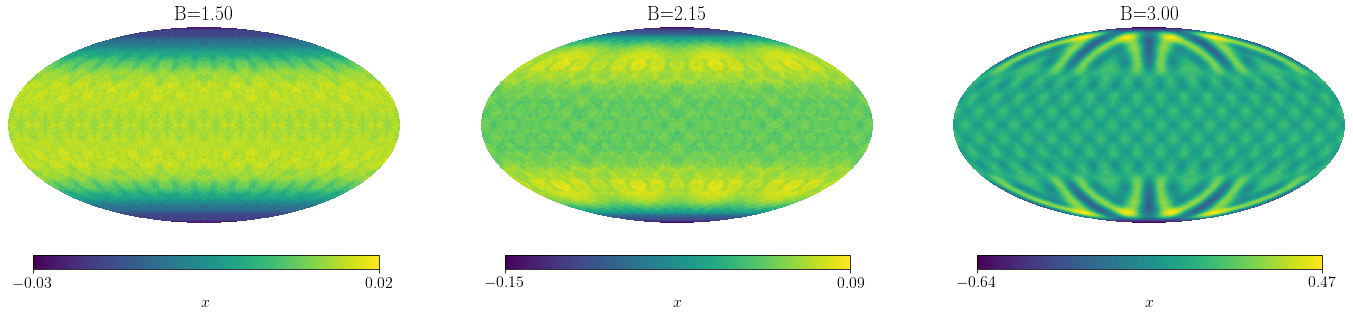

In [343]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
#minmax=[0,1]
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=False, cbar=False, notext=True, #min=minmax[0], max=minmax[1], 
                title='B=%.2f'%B[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$x$', fontsize=16)
    
run_name = f"chisquare_j{j[0]}_nside{nside}"
plt.savefig(f'figs/Bval_%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [345]:
j=[2]; B=2.1
g = 10; nside=128

ra, dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),nest=True, lonlat=True)
coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g*np.ones(ra.shape)})

ast_sf.nside=nside
basis_options = {'needlet':'chisquare', 'j':j, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}
# Process basis-specific options
ast_sf._process_basis_options(**basis_options)
ast_sf._load_spherical_basis()

Spherical basis file does not exist, generating... (this may take some time!)
Working on order 2.
100%|██████████| 192/192 [00:08<00:00, 23.89it/s]
Spherical basis file loaded


In [346]:
ast_sf.b = np.zeros((np.sum([hp.nside2npix(2**j[i]) for i in range(len(j))]), ast_sf.M, ast_sf.C))
ast_sf.b[95] = 1
node = hp.pix2ang(2**j[0], 95, lonlat=True)

Y = scipy.sparse.csr_matrix((ast_sf.basis['wavelet_w'], ast_sf.basis['wavelet_v'], ast_sf.basis['wavelet_u'])).toarray()
bmap = np.dot(Y, ast_sf.b[:,0,0])

node

(168.74999999999997, 0.0)

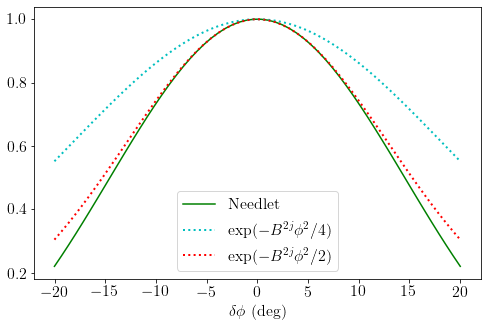

In [362]:
width=20
idx = np.unique(hp.ang2pix(nside, np.linspace(node[0]-width,node[0]+width,1000), np.zeros(1000), lonlat=True))
angle = hp.pix2ang(nside, idx, lonlat=True)

plt.figure(figsize=(8,5))
plt.plot(angle[0]-node[0], bmap[idx]/np.max(bmap), '-g', label='Needlet')

def Bshape(j,x,B):
    return np.exp(-B**(2.*j)*x**2 / 4.)
plt.plot(angle[0]-node[0], Bshape(j[0],np.deg2rad(angle[0]-node[0]),B), ':c', linewidth=2,
         label=r'$\exp(-B^{2j}\phi^2/4)$')

def Bshape(j,x,B):
    return np.exp(-B**(2.*j)*x**2 / 2.)
plt.plot(angle[0]-node[0], Bshape(j[0],np.deg2rad(angle[0]-node[0]),B), ':r', linewidth=2,
         label=r'$\exp(-B^{2j}\phi^2/2)$')

plt.xlabel(r'$\delta \phi$ (deg)')
plt.legend()

plt.savefig(f'figs/needlet-shape_%s.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

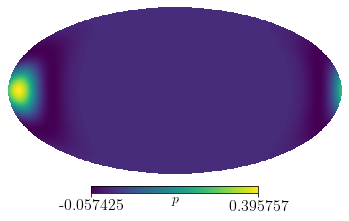

In [363]:
hp.mollview(bmap, nest=False, cbar=True, notext=True, title='', cmap='viridis', hold=True, unit=r'$p$')

# Construct basis

In [5]:
# Import dependencies
from numba import njit
from math import sin, cos
import sys
sys.path.append('/home/andy/Documents/Projects/GitRepos/selectionfunctions/selectionfunctions/')
from SelectionFunctionUtils import chisquare

In [6]:
# Function to compute needlet across sky
@njit
def pixel_space (Y, cos_gamma, window, start, end, legendre):
    '''Return the value of a needlet at gamma radians from the needlet centre.'''

    legendre[0] = 1.0
    legendre[1] = cos_gamma
    for cur_l in range(2, end + 1):
        legendre[cur_l] = ((cos_gamma * (2 * cur_l - 1) * legendre[cur_l - 1] - (cur_l - 1) * legendre[cur_l - 2])) / cur_l

    Y[:] = np.dot(window,legendre[start:end+1])

In [7]:
# Compute locations of pixels
npix = 1000
# Measurement locations
lon = np.linspace(np.pi-1,np.pi+1,npix)
cos_lon, sin_lon = np.cos(lon), np.sin(lon)
colat = np.zeros(npix) + np.pi/2
cos_colat, sin_colat = np.cos(colat), np.sin(colat)
# Needle location
colat_needle = np.array([np.pi/2]); lon_needle = np.array([np.pi])
# Parameter
cos_gamma = cos(colat_needle) * cos_colat + sin(colat_needle) * sin_colat * (cos(lon_needle) * cos_lon + sin(lon_needle) * sin_lon)

In [8]:
def Bshape(j,x,B,denominator=4):
    return np.exp(-B**(2.*j)*x**2 / denominator)

In [9]:
j=[5]; p=1.0; B=2.
weighting = chisquare(j, p=p, B=B)
npix_needle = hp.nside2npix(j[0])

# Initialise variables
Y = np.zeros(npix)
legendre = np.zeros((1+weighting.end(max(j)),npix))

start = weighting.start(j[0])
end = weighting.end(j[0])
modes = np.arange(start, end + 1, dtype = 'float')
window = weighting.window_function(modes,j[0])*(2.0*modes+1.0)/np.sqrt(4.0*np.pi*npix_needle)

pixel_space(Y, cos_gamma = cos_gamma, window = window, start = start, end = end, legendre = legendre)

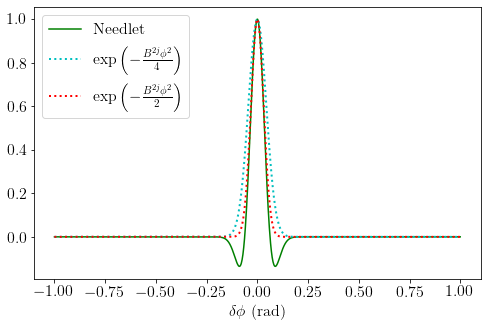

In [11]:
plt.figure(figsize=(8,5))
#plt.plot(angle[0]-node[0], bmap[idx]/np.max(bmap), '-g', label='Needlet')
plt.plot(lon-lon_needle[0], Y/np.max(Y), '-g', label='Needlet')

plt.plot(lon-lon_needle[0], Bshape(j[0],lon-lon_needle[0],B), ':c', linewidth=2,
         label=r'$\exp\left(-\frac{B^{2j}\phi^2}{4}\right)$')

plt.plot(lon-lon_needle[0], Bshape(j[0],lon-lon_needle[0],B, denominator=2), ':r', linewidth=2,
         label=r'$\exp\left(-\frac{B^{2j}\phi^2}{2}\right)$')

plt.xlabel(r'$\delta\phi$ (rad)')
plt.legend(loc='upper left')

#plt.savefig(f'figs/needlet-shape_%s.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

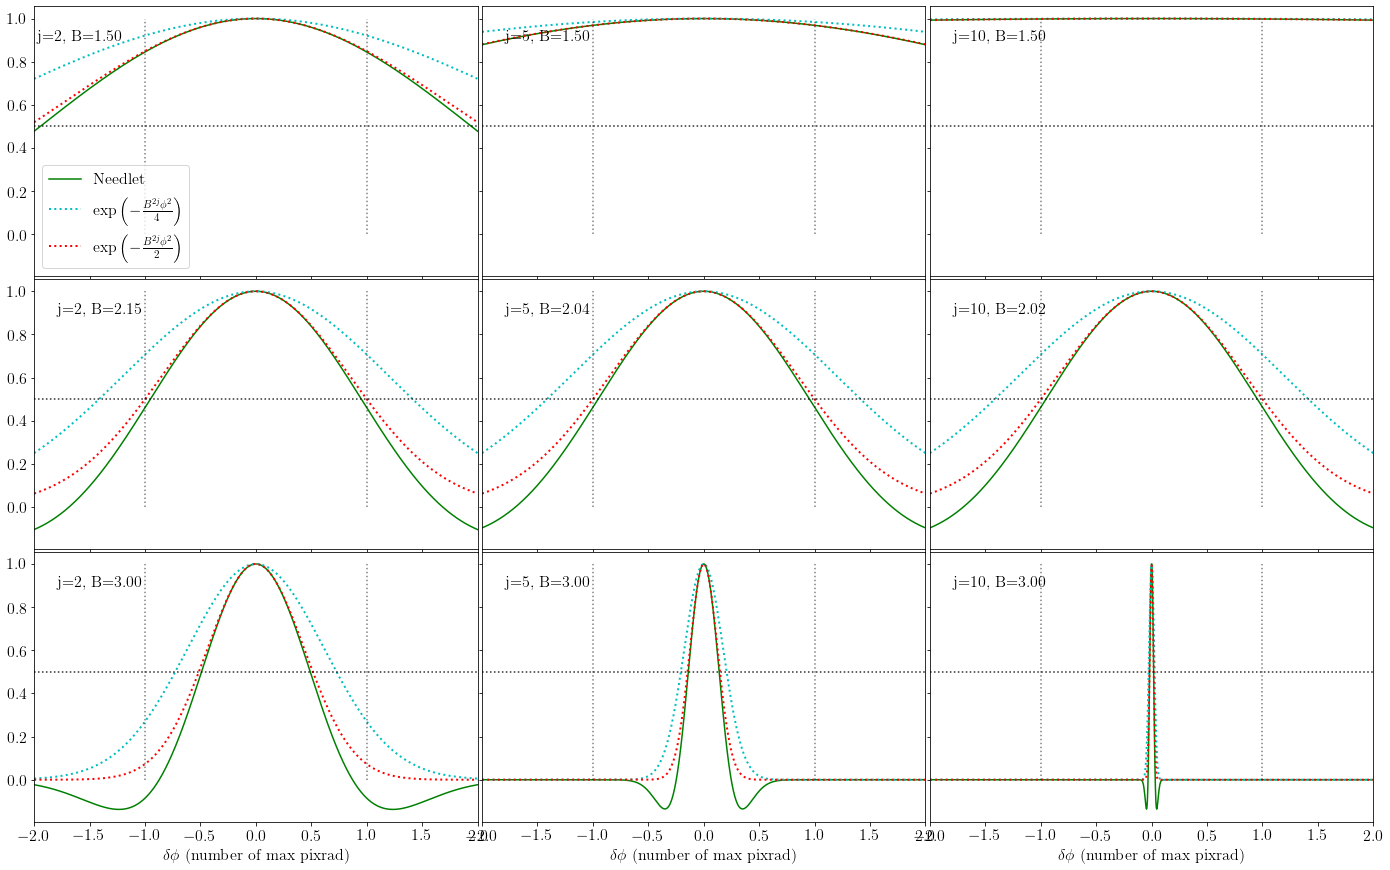

In [46]:
fig, axes = plt.subplots(3,3,figsize=(24,15), sharey=True, sharex=True)
p=1.0;

for jj,j in enumerate([[2],[5],[10]]):
    for ii,B in enumerate([1.5,2.,3.]):

        sep = hp.max_pixrad(2**j[0])
        if ii==1:
            B = (2*np.log(2)/sep**2 )**(1./(2*j[0]))
        
        weighting = chisquare(j, p=p, B=B)
        npix_needle = hp.nside2npix(2**j[0])

        # Measurement locations
        lon = np.linspace(np.pi- 2*sep,np.pi+ 2*sep,npix)
        cos_lon, sin_lon = np.cos(lon), np.sin(lon)
        cos_gamma = cos(colat_needle) * cos_colat + sin(colat_needle) * sin_colat * (cos(lon_needle) * cos_lon + sin(lon_needle) * sin_lon)

        # Initialise variables
        Y = np.zeros(npix)
        legendre = np.zeros((1+weighting.end(max(j)),npix))

        start = weighting.start(j[0])
        end = weighting.end(j[0])
        modes = np.arange(start, end + 1, dtype = 'float')
        window = weighting.window_function(modes,j[0])*(2.0*modes+1.0)/np.sqrt(4.0*np.pi*npix_needle)

        pixel_space(Y, cos_gamma = cos_gamma, window = window, start = start, end = end, legendre = legendre)

        plt.sca(axes[ii,jj])
        plt.plot((lon-lon_needle[0])/sep, Y/np.max(Y), '-g', label='Needlet')

        plt.plot((lon-lon_needle[0])/sep, Bshape(j[0],lon-lon_needle[0],B), ':c', linewidth=2,
                 label=r'$\exp\left(-\frac{B^{2j}\phi^2}{4}\right)$')

        plt.plot((lon-lon_needle[0])/sep, Bshape(j[0],lon-lon_needle[0],B, denominator=2), ':r', linewidth=2,
                 label=r'$\exp\left(-\frac{B^{2j}\phi^2}{2}\right)$')

        xlim = axes[ii,jj].get_xlim()
        plt.text(xlim[0] + (xlim[1]-xlim[0])*0.05,0.9,f"j={j[0]}, B={B:.2f}")
        
        plt.plot([1.,1.],[0.,1.],':k', alpha=0.5)
        plt.plot([-1.,-1.],[0.,1.],':k', alpha=0.5)
        plt.plot([-2.,2.],[0.5,0.5],':k', alpha=0.5)
        plt.plot([-2.,2.],[0.5,0.5],':k', alpha=0.5)
        plt.xlim(-2.,2.)
        
        
        if ii==2: plt.xlabel(r'$\delta\phi$ (number of max pixrad)')
    
plt.sca(axes[0,0]); plt.legend(loc='lower left')
plt.subplots_adjust(hspace=0.01, wspace=0.01)

#plt.savefig(f'figs/needlet-shape_B_j.png', bbox_inches='tight', facecolor='w', transparent=False)

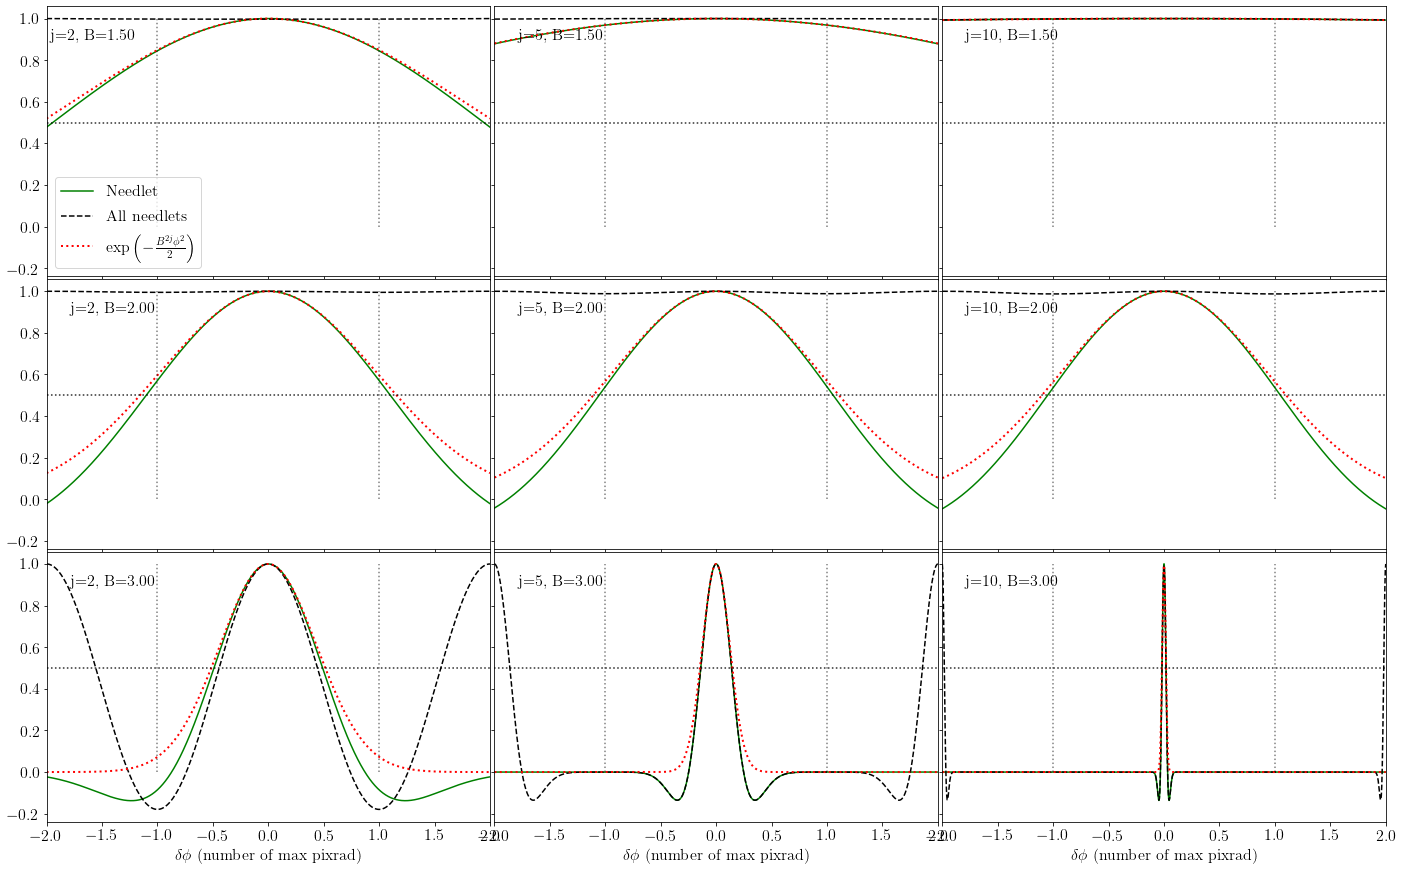

In [67]:
fig, axes = plt.subplots(3,3,figsize=(24,15), sharey=True, sharex=True)
p=1.0;

for jj,j in enumerate([[2],[5],[10]]):
    for ii,B in enumerate([1.5,2.,3.]):

        sep = hp.max_pixrad(2**j[0])
#         if ii==1:
#             B = (2*np.log(2)/sep**2 )**(1./(2*j[0]))
        
        weighting = chisquare(j, p=p, B=B)
        npix_needle = hp.nside2npix(2**j[0])

        # Measurement locations
        lon = np.linspace(np.pi- 2*sep,np.pi+ 2*sep,npix)
        cos_lon, sin_lon = np.cos(lon), np.sin(lon)
        # Needle location
        needlets = np.arange(-5,6)
        colat_needle = np.zeros(len(needlets)) + np.pi/2; lon_needle = 2*needlets*sep + np.pi
        Y = np.zeros(npix)
        
        plt.sca(axes[ii,jj])
        
        for ipix in range(len(colat_needle)):
            cos_gamma = cos(colat_needle[ipix]) * cos_colat + sin(colat_needle[ipix]) * sin_colat * (cos(lon_needle[ipix]) * cos_lon + sin(lon_needle[ipix]) * sin_lon)

            # Initialise variables
            Ys = np.zeros(npix)
            legendre = np.zeros((1+weighting.end(max(j)),npix))

            start = weighting.start(j[0])
            end = weighting.end(j[0])
            modes = np.arange(start, end + 1, dtype = 'float')
            window = weighting.window_function(modes,j[0])*(2.0*modes+1.0)/np.sqrt(4.0*np.pi*npix_needle)

            pixel_space(Ys, cos_gamma = cos_gamma, window = window, start = start, end = end, legendre = legendre)
            
            if needlets[ipix]==0.: plt.plot((lon-np.pi)/sep, Ys/np.max(Ys), '-g', label='Needlet')
            
            Y += Ys

        plt.plot((lon-np.pi)/sep, Y/np.max(Y), '--k', label='All needlets')

        plt.plot((lon-np.pi)/sep, Bshape(j[0],lon-np.pi,B, denominator=2), ':r', linewidth=2,
                 label=r'$\exp\left(-\frac{B^{2j}\phi^2}{2}\right)$')

        xlim = axes[ii,jj].get_xlim()
        plt.text(xlim[0] + (xlim[1]-xlim[0])*0.05,0.9,f"j={j[0]}, B={B:.2f}")

        plt.plot([1.,1.],[0.,1.],':k', alpha=0.5)
        plt.plot([-1.,-1.],[0.,1.],':k', alpha=0.5)
        plt.plot([-2.,2.],[0.5,0.5],':k', alpha=0.5)
        plt.plot([-2.,2.],[0.5,0.5],':k', alpha=0.5)
        plt.xlim(-2.,2.)


        if ii==2: plt.xlabel(r'$\delta\phi$ (number of max pixrad)')
    
plt.sca(axes[0,0]); plt.legend(loc='lower left')
plt.subplots_adjust(hspace=0.01, wspace=0.01)

plt.savefig(f'figs/needlet-shape_B_j_p{p}.png', bbox_inches='tight', facecolor='w', transparent=False)

## Normalization

In [111]:
# Compute locations of pixels
npix = 1000
# Measurement locations
lon = np.linspace(np.pi-1,np.pi+1,npix)
cos_lon, sin_lon = np.cos(lon), np.sin(lon)

In [336]:
M = 17; C = 1; nside=8; jmax=3; j=3
run_name = f"chisquare_normalisation_test"
basis_options = {'needlet':'chisquare', 'j':[j], 'B':2.0, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_results.h5"


colat_n, lon_n = hp.pix2ang(2**j, np.arange(hp.nside2npix(2**j)), lonlat=False)
index_n = np.argwhere(np.pi/2 - colat_n==0.)[0][0] + 3
center = lon
rad = hp.max_pixrad(2**j)

npix = 100
colat = np.zeros(npix)+np.pi/2
lon = np.linspace(lon_n[index_n]-4*rad, lon_n[index_n]+4*rad, npix)

In [337]:
# Import chisel
import sys
sys.path.append('../SelectionFunctionToolkit/')
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int64), 
                    np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int64), 
                basis_options,run_name,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = 10.,
                lengthscale_c = 10.,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.51],
                Mlim = [0,1],
                Clim = [0,1],
                stan_model_directory='/home/andy/Documents/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/',
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/PyOutput/'
                )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


Spherical basis file loaded
17 5
1 1
11.76% sparsity
0.00% sparsity
Incrementing wavelet_U
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [338]:
Y = pychisel._generate_spherical_basis(run_name, coords=(colat, lon))*pychisel.sigma[0]

Working on order 3.
lambda:  0.016362461737446838
100%|██████████| 768/768 [00:00<00:00, 1164.91it/s]
Expanding u


Text(0.5, 0, '$\\phi$')

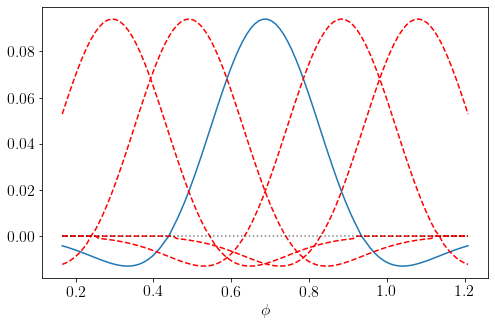

In [339]:
plt.figure(figsize=(8,5))

plt.plot(lon, Y.toarray()[:,index_n])
for idx in np.arange(-2,3):
    if idx!=0: plt.plot(lon, Y.toarray()[:,index_n+idx], '--r')
plt.plot([lon[0], lon[-1]],[0,0],':k', alpha=0.5)
#plt.plot([lon[0], lon[-1]],[1,1],':k', alpha=0.5)

plt.xlabel(r'$\phi$')

Text(0.5, 0, '$\\phi$')

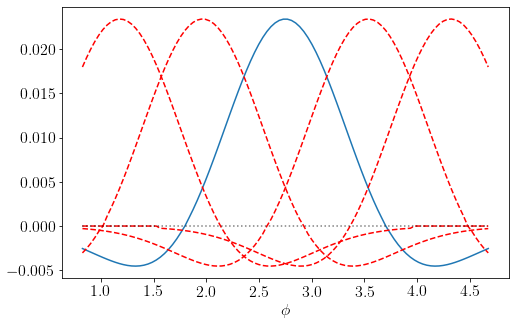

In [303]:
plt.figure(figsize=(8,5))

plt.plot(lon, Y.toarray()[:,index_n])
for idx in np.arange(-2,3):
    if idx!=0: plt.plot(lon, Y.toarray()[:,index_n+idx], '--r')
plt.plot([lon[0], lon[-1]],[0,0],':k', alpha=0.5)
#plt.plot([lon[0], lon[-1]],[1,1],':k', alpha=0.5)

plt.xlabel(r'$\phi$')

In [288]:
pychisel.weighting.normalise=True

In [289]:
pychisel.weighting.normalisation

array([ 1.        , 24.0337216 ,  5.65152193,  5.71031506,  5.48513587,
        5.38430668,  5.71027483,  5.73063352,  5.48513587,  5.33678939,
        5.38430668,  5.54933825,  5.71027483,  5.77677907,  5.73063352,
        5.61400983,  5.48513587,  5.38627017,  5.33678939,  5.33883445,
        5.38430668,  5.45973054,  5.54933825,  5.63739097,  5.71027483,
        5.75829838,  5.77677907,  5.76608029,  5.73063352,  5.6773563 ,
        5.61400983,  5.54790737,  5.48513587,  5.4302464 ,  5.38627017,
        5.35490936,  5.33678939,  5.33170568,  5.33883445,  5.35690046,
        5.38430668,  5.41923532,  5.45973054,  5.50377104,  5.54933825,
        5.59448304,  5.63739097,  5.67644399,  5.71027483,  5.73781016,
        5.75829838,  5.77131994,  5.77677907,  5.77487855,  5.76608029,
        5.75105612,  5.73063352,  5.7057409 ,  5.6773563 ,  5.64646246,
        5.61400983,  5.58088831,  5.54790737,  5.5157838 ,  5.48513587,
        5.45648252,  5.4302464 ,  5.40675946])

In [437]:
j=1

power_spectrum = lambda l: 1.#np.power(1.0+l,-2.5)
pychisel.weighting.lmax = 400
pychisel.weighting.compute_normalisation()
sigma=np.zeros(pychisel.weighting.lmax+1)
psi=np.zeros(pychisel.weighting.lmax+1)
for l in range(1,pychisel.weighting.lmax+1):
    sigma[l] = np.square(pychisel.weighting.window_function(l,j))*(2*l+1)*power_spectrum(l)
    psi[l] = pychisel.weighting.window_function(l,j)*(2*l+1)

In [433]:
pychisel.weighting.lmax

400

In [438]:
Nj = hp.nside2npix(2**j)
np.sqrt(np.sum(sigma))*np.sum(psi) / (Nj) / 0.08

1.0382058256117475

In [443]:
np.sqrt(np.sum(sigma))*np.sum(psi) / Nj

0.0830564660489398

In [439]:
sigma

array([0.00000000e+000, 2.75909581e-001, 5.60104519e-001, 1.56161387e-001,
       1.02149842e-002, 1.89277061e-004, 1.08677047e-006, 2.03283363e-009,
       1.27759317e-012, 2.75338506e-016, 2.06389775e-020, 5.43650648e-025,
       5.07107034e-030, 1.68495654e-035, 2.00353072e-041, 8.55709525e-048,
       1.31668603e-054, 7.31703586e-062, 1.47155856e-069, 1.07290250e-077,
       2.84001906e-086, 2.73279531e-095, 9.56950874e-105, 1.22061591e-114,
       5.67589075e-125, 9.62875837e-136, 5.96302957e-147, 1.34887634e-158,
       1.11508322e-170, 3.37031821e-183, 3.72598982e-196, 1.50723471e-209,
       2.23169461e-223, 1.20986297e-237, 2.40218416e-252, 1.74725325e-267,
       4.65678706e-283, 4.54874032e-299, 1.62875594e-315, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [435]:
psi

array([0.00000000e+000, 9.09795990e-001, 1.67347620e+000, 1.04552844e+000,
       3.03207615e-001, 4.56294605e-002, 3.75872534e-003, 1.74621031e-004,
       4.66037380e-006, 7.23286362e-008, 6.58345295e-010, 3.53609458e-012,
       1.12595186e-014, 2.13292819e-017, 2.41044375e-020, 1.62871100e-023,
       6.59170986e-027, 1.60030077e-030, 2.33340238e-034, 2.04556098e-038,
       1.07907730e-042, 3.42797606e-047, 6.56222442e-052, 7.57422918e-057,
       5.27369554e-062, 2.21600243e-067, 5.62174855e-073, 8.61325716e-079,
       7.97243647e-085, 4.45924628e-091, 1.50759868e-097, 3.08148968e-104,
       3.80867628e-111, 2.84711818e-118, 1.28744206e-125, 3.52214396e-133,
       5.83048416e-141, 5.84085203e-149, 3.54138703e-157, 1.29970191e-165,
       2.88756185e-174, 3.88397825e-183, 3.16313772e-192, 1.55987735e-201,
       4.65829152e-211, 8.42475658e-221, 9.22807633e-231, 6.12230436e-241,
       2.46033192e-251, 5.98923180e-262, 8.83220925e-273, 7.89058588e-284,
       4.27081235e-295, 1

In [270]:
0.006*25

0.15

In [279]:
np.sum(pychisel.weighting.window_function(5, np.arange(1,200))**2)

5.541011784866709

In [269]:
pychisel.weighting.compute_normalisation()
pychisel.weighting.normalisation

[1.         9.51292303 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         

 1.         1.         1.         1.        ]
[1.         9.51292303 5.36785321 5.74297157 5.33968121 5.54101178
 5.77642588 5.61839904 5.38852078 5.3381734  5.45770456 5.63559383
 5.75762023 5.76652201 5.67838274 5.54896175 5.43100267 5.35526462
 5.33169055 5.35660601 5.41877169 5.50324623 5.59399046 5.67605379
 5.73756375 5.77122907 5.77492963 5.75121838 5.7059759  5.64673215
 5.58116029 5.51603371 5.4566942  5.4069239  5.36906535 5.34425414
 5.33267452 5.33379043 5.34653505 5.36945859 5.40084255 5.4387905
 5.48130487 5.52635685 5.57195372 5.61620495 5.65738609 5.69399739
 5.72481309 5.74891735 5.76572359 5.77497548 5.77672999 5.77132455
 5.75933225 5.74150941 5.71874059 5.6919851  5.6622286  5.63044194
 5.59754853 5.56440029 5.53176173 5.50030102 5.47058682 5.44308961
 5.41818606 5.39616559 5.37723805 5.36154195 5.34915263 5.34009014
 5.33432648 5.33179227 5.33238262 5.33596238 5.34237064 5.35142483
 5.36292414 5.37665272 5.39238237 5.40987517 5.4288858  5.44916376
 5.47045559 5.492

array([1.        , 9.51292303, 5.36785321, 5.74297157, 5.33968121,
       5.54101178, 5.77642588, 5.61839904, 5.38852078, 5.3381734 ,
       5.45770456, 5.63559383, 5.75762023, 5.76652201, 5.67838274,
       5.54896175, 5.43100267, 5.35526462, 5.33169055, 5.35660601,
       5.41877169, 5.50324623, 5.59399046, 5.67605379, 5.73756375,
       5.77122907, 5.77492963, 5.75121838, 5.7059759 , 5.64673215,
       5.58116029, 5.51603371, 5.4566942 , 5.4069239 , 5.36906535,
       5.34425414, 5.33267452, 5.33379043, 5.34653505, 5.36945859,
       5.40084255, 5.4387905 , 5.48130487, 5.52635685, 5.57195372,
       5.61620495, 5.65738609, 5.69399739, 5.72481309, 5.74891735,
       5.76572359, 5.77497548, 5.77672999, 5.77132455, 5.75933225,
       5.74150941, 5.71874059, 5.6919851 , 5.6622286 , 5.63044194,
       5.59754853, 5.56440029, 5.53176173, 5.50030102, 5.47058682,
       5.44308961, 5.41818606, 5.39616559, 5.37723805, 5.36154195,
       5.34915263, 5.34009014, 5.33432648, 5.33179227, 5.33238

In [220]:
pychisel.sigma

array([0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999702,
       0.00999702, 0.00999702, 0.00999702, 0.00999702, 0.00999

In [129]:
print(-1, pychisel.sigma[0])
i=1
for j in range(1,jmax+1):
    print(j, pychisel.sigma[i])
    i+=hp.nside2npix(j)

-1 0.043052875936373254
1 0.043052875936373254
2 0.043052875936373254


IndexError: index 61 is out of bounds for axis 0 with size 48

Text(0.5, 0, '$\\phi$')

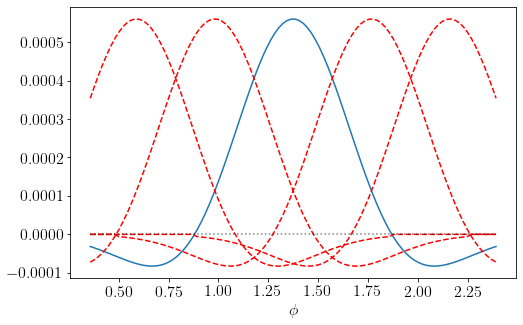

In [54]:
plt.figure(figsize=(8,5))

plt.plot(lon, Y.toarray()[:,index_n])
for idx in np.arange(-2,3):
    if idx!=0: plt.plot(lon, Y.toarray()[:,index_n+idx], '--r')
plt.plot([lon[0], lon[-1]],[0,0],':k', alpha=0.5)
#plt.plot([lon[0], lon[-1]],[1,1],':k', alpha=0.5)

plt.xlabel(r'$\phi$')

Text(0.5, 0, '$\\phi$')

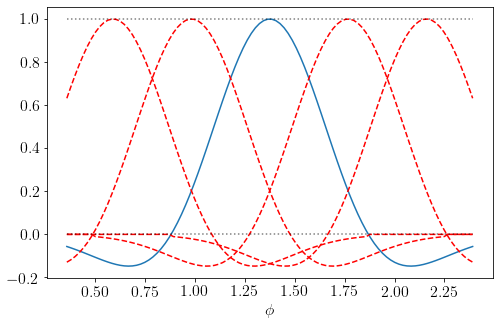

In [92]:
plt.figure(figsize=(8,5))

plt.plot(lon, Y.toarray()[:,index_n])
for idx in np.arange(-2,3):
    if idx!=0: plt.plot(lon, Y.toarray()[:,index_n+idx], '--r')
plt.plot([lon[0], lon[-1]],[0,0],':k', alpha=0.5)
plt.plot([lon[0], lon[-1]],[1,1],':k', alpha=0.5)

plt.xlabel(r'$\phi$')